# **Dataset Preparation**

### Install `wfdb` Library

This code installs the `wfdb` Python library, which is used for reading, writing, and processing physiological signal data (such as ECG or other bio-signals). 

- The `!pip install -q wfdb` command is used to install the `wfdb` library via pip in a Jupyter notebook or similar environment.
- The `-q` flag stands for "quiet" mode, which suppresses most of the installation output for a cleaner experience.
  
By running this cell, the `wfdb` library will be available for use in subsequent code cells.


In [1]:
!pip install -q wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 5.9 MB/s eta 0:00:00


### Import library

In [2]:
import os
import wfdb
import numpy as np
import pandas as pd
from scipy.signal import resample
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, Model
from keras.layers import Conv1D, AvgPool1D, MaxPooling1D, Flatten, Dense, Dropout, Softmax, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.optimizers import Adam 
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras import regularizers
from sklearn.preprocessing import StandardScaler

## *Datasets*

### 1. [MIT-BIH Arrhythmia Database](https://physionet.org/content/mitdb/1.0.0/)
- *Description:* Contains normal sinus rhythm ECG signals.  
- *Sampling Frequency:* 360 Hz.  
- *Leads:* MLII and V1.  
- *Files:*
  - .atr → Annotation file.  
  - .dat → Information about the beats.  
  - .header → Metadata of the file record.


In [3]:
from scipy.signal import resample

def resample_signal(signal, orig_fs, target_fs):
    new_length = int(len(signal) * (target_fs / orig_fs))
    resampled_signal = resample(signal, new_length)
    return resampled_signal


In [4]:
import wfdb
import numpy as np

def extract_beats_from_multiple_files(record_list):
    beat_labels = []
    beats = []
    
    for name in record_list:
        record_name = f"/kaggle/input/mit-ar/mit-bih-arrhythmia-database-1.0.0/{name}"  # Adjust path as needed
        
        try:
            record = wfdb.rdrecord(record_name, channels=[0])  # Load lead 0 (MLII)
            annotation = wfdb.rdann(record_name, 'atr')
            
            # Resample signal to 125 Hz from 360 Hz
            signal = record.p_signal.flatten()  # Convert 2D signal to 1D
            fs = record.fs  # Original 360 Hz
            target_fs = 125  # New sampling frequency
            resampled_signal = resample_signal(signal, fs, target_fs)
            
            # Get R-peak locations and annotations
            r_peaks = np.round(annotation.sample * (target_fs / fs)).astype(int)  # Adjust R-peaks for new sampling rate
            # print(r_peaks)

            labels = annotation.symbol
            
            # Define window size (1 second * target_fs)
            window_size = int(1.0 * target_fs)  # 125 samples at 125 Hz
            
            for i in range(1, len(r_peaks) - 1):  # Ignore first & last beats
                start = max(0, r_peaks[i] - window_size // 2)
                end = min(len(resampled_signal), r_peaks[i] + window_size // 2)
                beat = resampled_signal[start:end]
                # print(len(beat))
                

                # Append only if the extracted beat matches the window size
                if len(beat) == 124:
                    beats.append(beat)
                    beat_labels.append(labels[i])
                    
        except Exception as e:
            print(f"Error processing record {name}: {e}")
            continue
    
    return beat_labels, beats

# Your record list
record_list = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', 
               '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', 
               '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', 
               '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', 
               '222', '223', '228', '230', '231', '232', '233', '234']

# Extract beats and labels
labels, extracted_beats = extract_beats_from_multiple_files(record_list)

# Basic validation
print(f"Total beats extracted: {len(extracted_beats)}")
print(f"Total labels: {len(labels)}")
print(f"Length of first beat: {len(extracted_beats[0]) if extracted_beats else 'N/A'}")


Total beats extracted: 112522
Total labels: 112522
Length of first beat: 124


In [5]:
# Convert beats to a NumPy array with 216 columns
print("Converting beats to array...")
signals = np.array(extracted_beats)  # Shape: (~108,000, 216)

# Create DataFrame with 216 signal columns and 1 label column
print("Creating DataFrame with 124 columns...")
signal_columns = [f"signal_{i}" for i in range(124)]  # Column names: signal_0, signal_1, ..., signal_215
df = pd.DataFrame(signals, columns=signal_columns)
df["qrs_label"] = labels  # Add label column

# Save to CSV
csv_path = "mitbih_beats_expanded.csv"
df.to_csv(csv_path, index=False)
print(f"CSV saved as '{csv_path}'")

# Validate the CSV
print("Validating CSV...")
df_loaded = pd.read_csv(csv_path)
print(f"CSV Shape: {df_loaded.shape}")
print(f"Sample data:\n{df_loaded.head()}")

# Validate signals and labels shapes
signals_loaded = df_loaded[[f"signal_{i}" for i in range(124)]].values
labels_loaded = df_loaded["qrs_label"].values
print(f"Signals Shape: {signals_loaded.shape}")
print(f"Labels Shape: {labels_loaded.shape}")

Converting beats to array...
Creating DataFrame with 124 columns...
CSV saved as 'mitbih_beats_expanded.csv'
Validating CSV...
CSV Shape: (112522, 125)
Sample data:
   signal_0  signal_1  signal_2  signal_3  signal_4  signal_5  signal_6  \
0 -0.334380 -0.304536 -0.294782 -0.272792 -0.254634 -0.248905 -0.242003   
1 -0.364248 -0.329795 -0.324911 -0.314803 -0.308180 -0.313525 -0.306266   
2 -0.387781 -0.341803 -0.335438 -0.317750 -0.310146 -0.302364 -0.305135   
3 -0.318040 -0.321295 -0.290350 -0.294059 -0.271101 -0.296452 -0.282856   
4 -0.414569 -0.367256 -0.361640 -0.312822 -0.313194 -0.306396 -0.318554   

   signal_7  signal_8  signal_9  ...  signal_115  signal_116  signal_117  \
0 -0.251915 -0.248386 -0.252462  ...   -0.318705   -0.306234   -0.326136   
1 -0.316192 -0.303476 -0.319028  ...   -0.353315   -0.351430   -0.363160   
2 -0.309122 -0.310087 -0.316781  ...   -0.330653   -0.318613   -0.328874   
3 -0.302860 -0.281703 -0.294438  ...   -0.328417   -0.330234   -0.320145   
4 -0

In [6]:
import pandas as pd

# Load dataset
csv_file = "/kaggle/working/mitbih_beats_expanded.csv"
df = pd.read_csv(csv_file)

# Separate the last column
label_column = df.iloc[:, -1]  # Extract last column (qrs_label)
df = df.iloc[:, :-1].astype(float)  # Convert all other columns to float

# Reattach the label column
df["qrs_label"] = label_column  # Add label back as the last column

# Save back to CSV
df.to_csv("/kaggle/working/mitbih_beats_expanded.csv", index=False)

# Display info
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112522 entries, 0 to 112521
Columns: 125 entries, signal_0 to qrs_label
dtypes: float64(124), object(1)
memory usage: 107.3+ MB
None


In [7]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import lfilter

def pan_tompkins_qrs(signal, fs=125):
    """ Implements the Pan-Tompkins algorithm for QRS detection. """
    # Step 1: Bandpass Filter (5-12 Hz approximated)
    # Low-pass filter: H(z) = (1 - z^-6)^2 / (1 - z^-1)^2
    low_pass_b = np.array([1, 0, 0, 0, 0, 0, -2, 0, 0, 0, 0, 0, 1])
    low_pass_a = np.array([1, -2, 1])
    low_pass_signal = lfilter(low_pass_b, low_pass_a, signal)

    # High-pass filter: H(z) = (-1 + 32z^-16 + z^-32) / (1 + z^-1)
    high_pass_b = np.array([-1] + [0]*15 + [32] + [0]*15 + [-1])
    high_pass_a = np.array([1, 1])
    bandpass_signal = lfilter(high_pass_b, high_pass_a, low_pass_signal)

    # Step 2: Derivative (5-point derivative)
    deriv_b = np.array([1, 2, 0, -2, -1]) * (1 / (8 * (1/fs)))
    deriv_a = np.array([1])
    deriv_signal = lfilter(deriv_b, deriv_a, bandpass_signal)

    # Step 3: Squaring
    squared_signal = deriv_signal ** 2

    # Step 4: Moving-Window Integration (30 samples = 150ms at 125 Hz)
    window_size = int(0.150 * fs)  # 150 ms window
    integ_b = np.ones(window_size) / window_size
    integ_a = np.array([1])
    integ_signal = lfilter(integ_b, integ_a, squared_signal)

    # Step 5: Adaptive Thresholding
    peaks = []
    spki = np.max(integ_signal[:int(fs*2)])  # Initial signal peak (first 2s estimate)
    npki = np.mean(integ_signal[:int(fs*2)])  # Initial noise peak
    threshold_i1 = npki + 0.25 * (spki - npki)
    threshold_i2 = 0.5 * threshold_i1

    refractory_period = int(0.200 * fs)  # 200 ms
    last_peak = -refractory_period - 1

    for i in range(len(integ_signal)):
        if i - last_peak <= refractory_period:
            continue
        if integ_signal[i] > threshold_i1:
            peaks.append(i)
            last_peak = i
            spki = 0.125 * integ_signal[i] + 0.875 * spki
        elif integ_signal[i] > threshold_i2 and (i > int(1.66 * fs)):  # Search-back after 1.66s
            peaks.append(i)
            last_peak = i
            spki = 0.25 * integ_signal[i] + 0.75 * spki
        npki = 0.125 * integ_signal[i] + 0.875 * npki if integ_signal[i] < threshold_i2 else npki
        threshold_i1 = npki + 0.25 * (spki - npki)
        threshold_i2 = 0.5 * threshold_i1

    # Refine peaks to original signal's R-peaks
    r_peaks = []
    for peak in peaks:
        window = signal[max(0, peak-10):min(len(signal), peak+10)]
        if len(window) > 0:
            r_peak_idx = max(0, peak-10) + np.argmax(window)
            r_peaks.append(r_peak_idx)

    return r_peaks

def extract_features(signal_array, fs=125):
    """ Extracts features from a single ECG beat with Pan-Tompkins QRS detection. """
    features = {}

    # Statistical Features
    features["mean_amplitude"] = np.mean(signal_array)
    features["median_amplitude"] = np.median(signal_array)
    features["skewness"] = skew(signal_array)
    features["kurtosis"] = kurtosis(signal_array)
    features["min_amplitude"] = np.min(signal_array)
    features["max_amplitude"] = np.max(signal_array)
    features["rms"] = np.sqrt(np.mean(signal_array**2))

    # QRS Detection using Pan-Tompkins
    r_peaks = pan_tompkins_qrs(signal_array, fs)
    
    if r_peaks:
        # Assume the most prominent peak in the segment is the R-peak
        r_peak_index = r_peaks[0]  # Take the first detected peak
        features["r_peak_amplitude"] = signal_array[r_peak_index]

        # QRS Duration: Find Q and S points around the R-peak
        q_window = signal_array[max(0, r_peak_index-15):r_peak_index]  # 120ms before R
        s_window = signal_array[r_peak_index:min(len(signal_array), r_peak_index+15)]  # 120ms after R
        q_idx = max(0, r_peak_index-15) + np.argmin(q_window) if len(q_window) > 0 else r_peak_index
        s_idx = r_peak_index + np.argmin(s_window) if len(s_window) > 0 else r_peak_index
        features["qrs_duration"] = (s_idx - q_idx) / fs  # Convert to seconds
    else:
        # Default values if no QRS is detected
        features["r_peak_amplitude"] = np.max(signal_array)  # Fallback to max amplitude
        r_peak_index = np.argmax(signal_array)
        q_window = signal_array[max(0, r_peak_index-15):r_peak_index]
        s_window = signal_array[r_peak_index:min(len(signal_array), r_peak_index+15)]
        q_idx = max(0, r_peak_index-15) + np.argmin(q_window) if len(q_window) > 0 else r_peak_index
        s_idx = r_peak_index + np.argmin(s_window) if len(s_window) > 0 else r_peak_index
        features["qrs_duration"] = (s_idx - q_idx) / fs

    return features

# Load CSV file
csv_file = "/kaggle/working/mitbih_beats_expanded.csv"
df = pd.read_csv(csv_file)

# Ensure all signal columns are float (excluding label)
df.iloc[:, :-1] = df.iloc[:, :-1].astype(float)

# Extract features for all rows
feature_list = []
for index, row in df.iterrows():
    signal_array = row.iloc[:-1].values.astype(float)  # Ensure numeric conversion
    label = row.iloc[-1]  # Get label correctly

    features = extract_features(signal_array, fs=125)
    features["qrs_label"] = label  # Add label

    feature_list.append(features)

# Convert to DataFrame
features_df = pd.DataFrame(feature_list)

# Save as a new CSV file
output_file = "/kaggle/working/mitbih_features.csv"
features_df.to_csv(output_file, index=False)

print(f"Feature dataset saved to: {output_file}")
print(features_df.head())

Feature dataset saved to: /kaggle/working/mitbih_features.csv
   mean_amplitude  median_amplitude  skewness   kurtosis  min_amplitude  \
0       -0.309618         -0.318867  5.085156  30.700195      -0.525477   
1       -0.332099         -0.345146  5.934637  42.640946      -0.575860   
2       -0.333102         -0.352372  5.747786  40.746995      -0.630194   
3       -0.331787         -0.335326  5.546032  36.469983      -0.540349   
4       -0.325670         -0.330128  5.547618  39.283392      -0.527537   

   max_amplitude       rms  r_peak_amplitude  qrs_duration qrs_label  
0       0.830950  0.353071         -0.380917         0.232         N  
1       0.963025  0.366066         -0.386955         0.096         N  
2       0.844873  0.363813         -0.375773         0.152         N  
3       0.658045  0.359593         -0.385386         0.200         N  
4       0.894193  0.357473         -0.392173         0.136         N  


In [8]:
features_df.head()

,mean_amplitude,median_amplitude,skewness,kurtosis,min_amplitude,max_amplitude,rms,r_peak_amplitude,qrs_duration,qrs_label
0,-0.309618,-0.318867,5.085156,30.700195,-0.525477,0.830950,0.353071,-0.380917,0.232,N
1,-0.332099,-0.345146,5.934637,42.640946,-0.575860,0.963025,0.366066,-0.386955,0.096,N
2,-0.333102,-0.352372,5.747786,40.746995,-0.630194,0.844873,0.363813,-0.375773,0.152,N
3,-0.331787,-0.335326,5.546032,36.469983,-0.540349,0.658045,0.359593,-0.385386,0.200,N
4,-0.325670,-0.330128,5.547618,39.283392,-0.527537,0.894193,0.357473,-0.392173,0.136,N


In [9]:
label = ["N", "V", "F"]
features_df['qrs_label'] = features_df.iloc[:, -1].apply(lambda x: x if x in label else 'Q')

In [10]:
features_df.iloc[:, -1].value_counts()

qrs_label
N    74997
Q    29594
V     7129
F      802
Name: count, dtype: int64

In [11]:
print("Encoding labels manually...")
label_mapping = {'N': 0, 'V': 1, 'F': 2, 'Q': 3}  # Custom mapping
features_df["qrs_label"] = features_df["qrs_label"].map(label_mapping)

Encoding labels manually...


In [12]:
features_df.head()

,mean_amplitude,median_amplitude,skewness,kurtosis,min_amplitude,max_amplitude,rms,r_peak_amplitude,qrs_duration,qrs_label
0,-0.309618,-0.318867,5.085156,30.700195,-0.525477,0.830950,0.353071,-0.380917,0.232,0
1,-0.332099,-0.345146,5.934637,42.640946,-0.575860,0.963025,0.366066,-0.386955,0.096,0
2,-0.333102,-0.352372,5.747786,40.746995,-0.630194,0.844873,0.363813,-0.375773,0.152,0
3,-0.331787,-0.335326,5.546032,36.469983,-0.540349,0.658045,0.359593,-0.385386,0.200,0
4,-0.325670,-0.330128,5.547618,39.283392,-0.527537,0.894193,0.357473,-0.392173,0.136,0


In [13]:
features_df.to_csv('features_data.csv', index = False)

In [14]:
# Separate features and labels
features = features_df.iloc[:, :-1]  # All columns except the last one
labels = features_df.iloc[:, -1]     # Last column (qrs_label)

# Apply Z-score normalization
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)  # Standardization

# Convert back to DataFrame
normalized_df = pd.DataFrame(normalized_features, columns=features.columns)
normalized_df["qrs_label"] = labels  # Add label column back

# Save to new CSV file
normalized_csv_file = "/kaggle/working/mitbih_normalized.csv"
normalized_df.to_csv(normalized_csv_file, index=False)

print(f"Normalized dataset saved to: {normalized_csv_file}")
print(normalized_df.head())


Normalized dataset saved to: /kaggle/working/mitbih_normalized.csv
   mean_amplitude  median_amplitude  skewness  kurtosis  min_amplitude  \
0        0.042817          0.156361  1.408732  1.837574       0.728515   
1       -0.031449          0.070123  1.861884  3.050729       0.639265   
2       -0.034764          0.046409  1.762209  2.858308       0.543016   
3       -0.030418          0.102347  1.654584  2.423772       0.702171   
4       -0.010212          0.119405  1.655430  2.709609       0.724866   

   max_amplitude       rms  r_peak_amplitude  qrs_duration  qrs_label  
0      -0.503378 -0.518525         -0.340651      1.241886          0  
1      -0.288937 -0.470382         -0.354459     -1.248547          0  
2      -0.480772 -0.478728         -0.328884     -0.223074          0  
3      -0.784111 -0.494363         -0.350872      0.655902          0  
4      -0.400694 -0.502216         -0.366395     -0.516067          0  


### Machine learning Model 

In [15]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

In [16]:
# Loading the merged dataset
data = pd.read_csv('/kaggle/working/mitbih_normalized.csv')

data.head()

,mean_amplitude,median_amplitude,skewness,kurtosis,min_amplitude,max_amplitude,rms,r_peak_amplitude,qrs_duration,qrs_label
0,0.042817,0.156361,1.408732,1.837574,0.728515,-0.503378,-0.518525,-0.340651,1.241886,0
1,-0.031449,0.070123,1.861884,3.050729,0.639265,-0.288937,-0.470382,-0.354459,-1.248547,0
2,-0.034764,0.046409,1.762209,2.858308,0.543016,-0.480772,-0.478728,-0.328884,-0.223074,0
3,-0.030418,0.102347,1.654584,2.423772,0.702171,-0.784111,-0.494363,-0.350872,0.655902,0
4,-0.010212,0.119405,1.655430,2.709609,0.724866,-0.400694,-0.502216,-0.366395,-0.516067,0


In [17]:
X = data.iloc[:, :-1]
X.head()

,mean_amplitude,median_amplitude,skewness,kurtosis,min_amplitude,max_amplitude,rms,r_peak_amplitude,qrs_duration
0,0.042817,0.156361,1.408732,1.837574,0.728515,-0.503378,-0.518525,-0.340651,1.241886
1,-0.031449,0.070123,1.861884,3.050729,0.639265,-0.288937,-0.470382,-0.354459,-1.248547
2,-0.034764,0.046409,1.762209,2.858308,0.543016,-0.480772,-0.478728,-0.328884,-0.223074
3,-0.030418,0.102347,1.654584,2.423772,0.702171,-0.784111,-0.494363,-0.350872,0.655902
4,-0.010212,0.119405,1.655430,2.709609,0.724866,-0.400694,-0.502216,-0.366395,-0.516067


In [18]:
y = data.iloc[:, -1]
y.head()

0    0
1    0
2    0
3    0
4    0
Name: qrs_label, dtype: int64

In [19]:
print(f"The Shape of the X: {X.shape}")
print(f"The Shape of the y: {y.shape}")

The Shape of the X: (112522, 9)
The Shape of the y: (112522,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

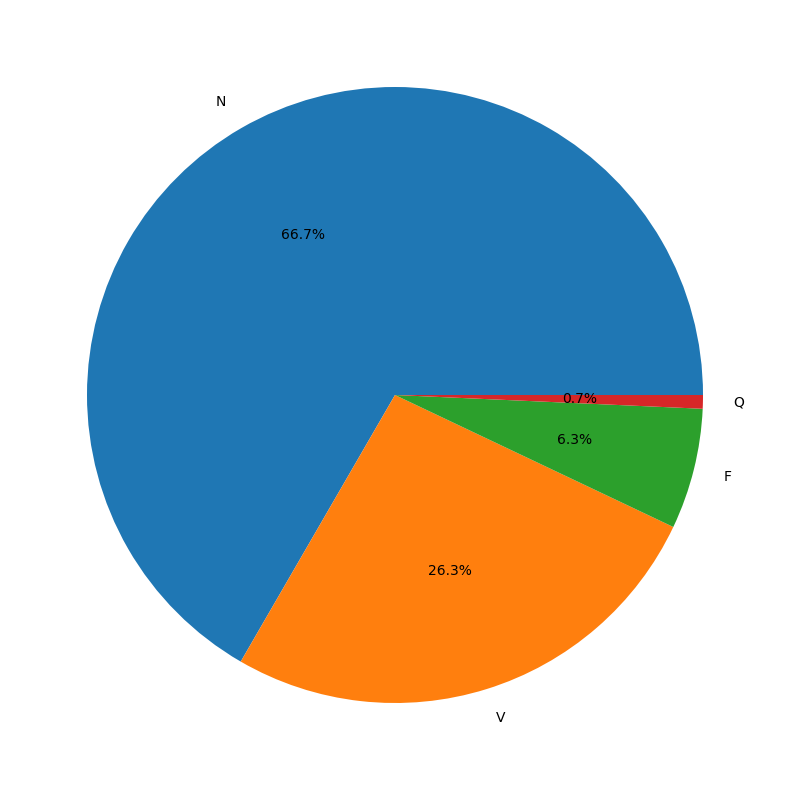

In [21]:
per_classes = data.iloc[:, -1].value_counts()
plt.figure(figsize=(20,10))
plt.pie(per_classes, labels=['N', 'V', 'F', 'Q'], autopct='%1.1f%%')
plt.show()

In [22]:
# importing library
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [23]:
knc = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='euclidean')
dtc = DecisionTreeClassifier(max_depth=10, criterion='entropy', min_samples_split=4, random_state=42)
lrc = LogisticRegression(solver='saga', multi_class='multinomial', penalty='l1', C=0.5, max_iter=1000)
rfc = RandomForestClassifier(n_estimators=200, max_depth=15, criterion='entropy', min_samples_split=4, random_state=42, n_jobs=-1)
abc = AdaBoostClassifier(n_estimators=100, learning_rate=0.8, random_state=42)
etc = ExtraTreesClassifier(n_estimators=200, max_depth=15, criterion='gini', min_samples_split=4, random_state=42, n_jobs=-1)
gbdt = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=5, min_samples_split=4, random_state=42)

In [24]:
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, 
    precision_score, recall_score, f1_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

def plot_metrics(models, X_train, y_train, X_test, y_test):
    num_classes = len(np.unique(y_test))  # Get number of unique classes
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test)) if num_classes > 2 else y_test

    for name, model in models.items():
        print(f"Training and plotting for {name}")
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)  # Get probability scores for each class
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        # Plot metrics
        plt.figure(figsize=(20, 6))

        # ROC Curve (Only for multiclass)
        if num_classes > 2:
            plt.subplot(1, 3, 1)
            for i in range(num_classes):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {name}')
            plt.legend(loc='lower right')

        # Precision-Recall Curve (Only for multiclass)
        plt.subplot(1, 3, 2)
        for i in range(num_classes):
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
            plt.plot(recall, precision, lw=2, label=f'Class {i}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {name}')
        plt.legend(loc='lower left')

        # Confusion Matrix
        plt.subplot(1, 3, 3)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")

        plt.tight_layout()
        plt.show()


In [25]:
clfs = {
    'DT': dtc,  
    'LR': lrc,
    'KN' : knc, 
    'RF': rfc, 
    'AdaBoost': abc,  
    'ETC': etc,
    'GBDT':gbdt
}

Training and plotting for DT


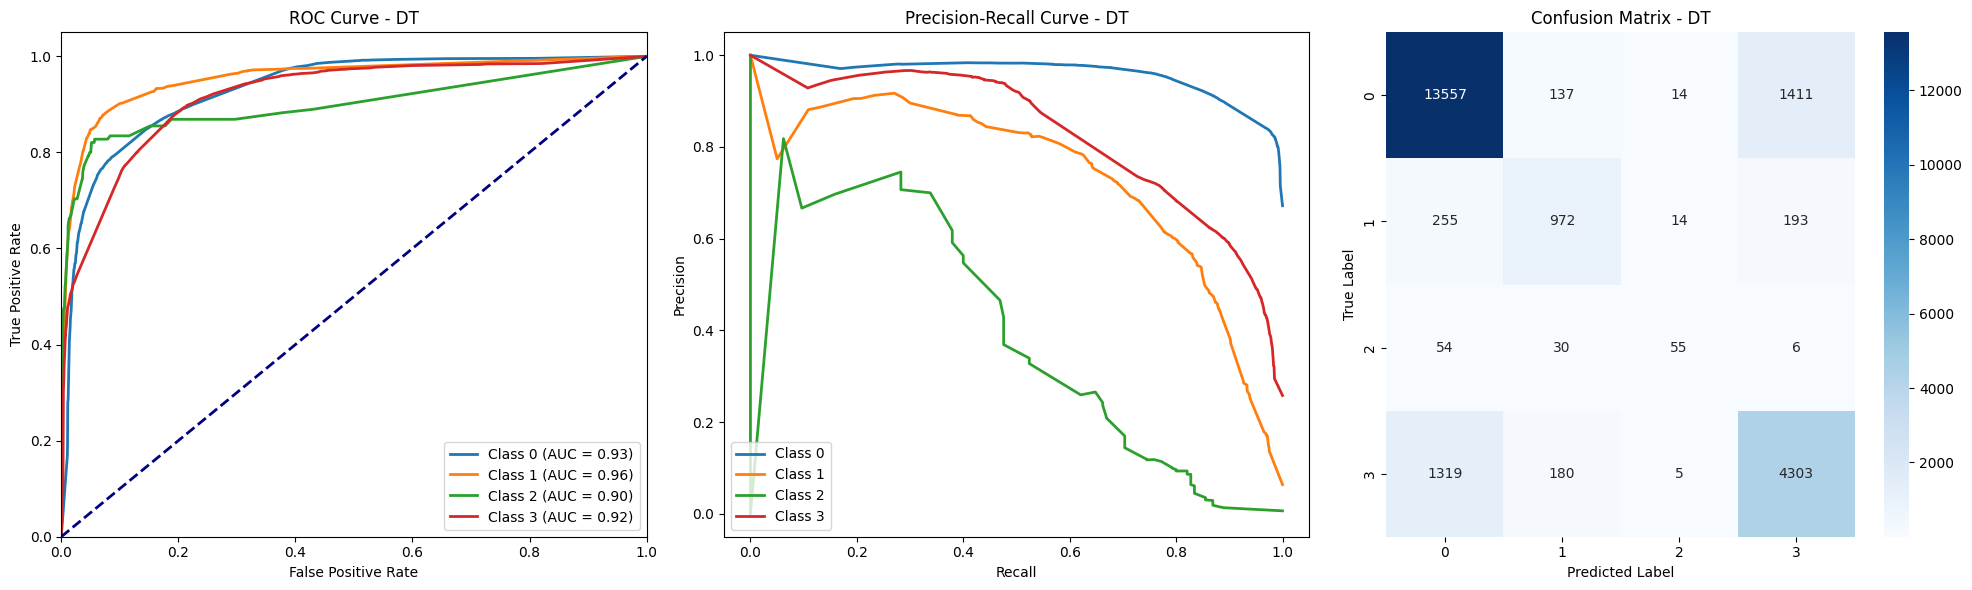

Training and plotting for LR


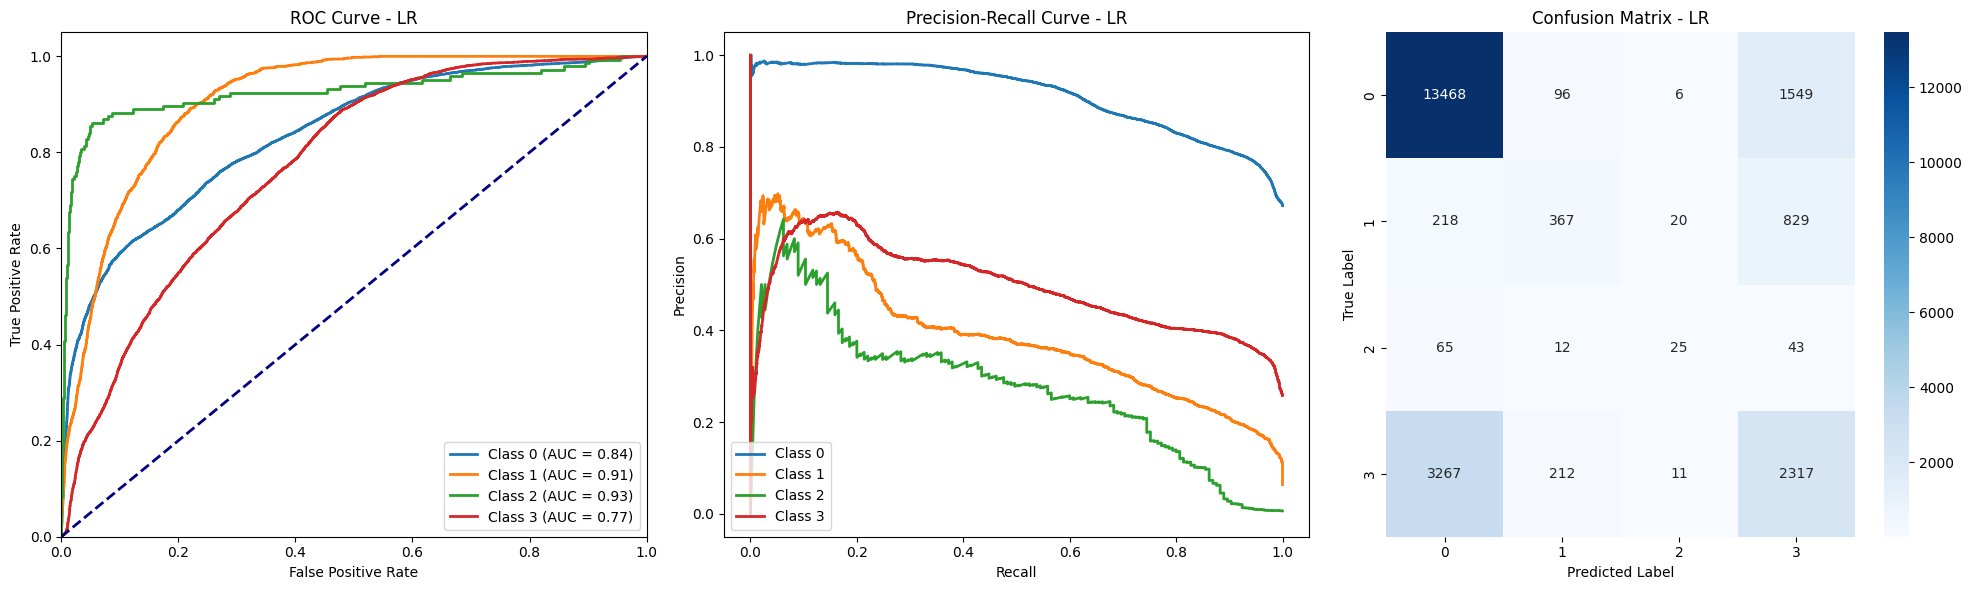

Training and plotting for KN


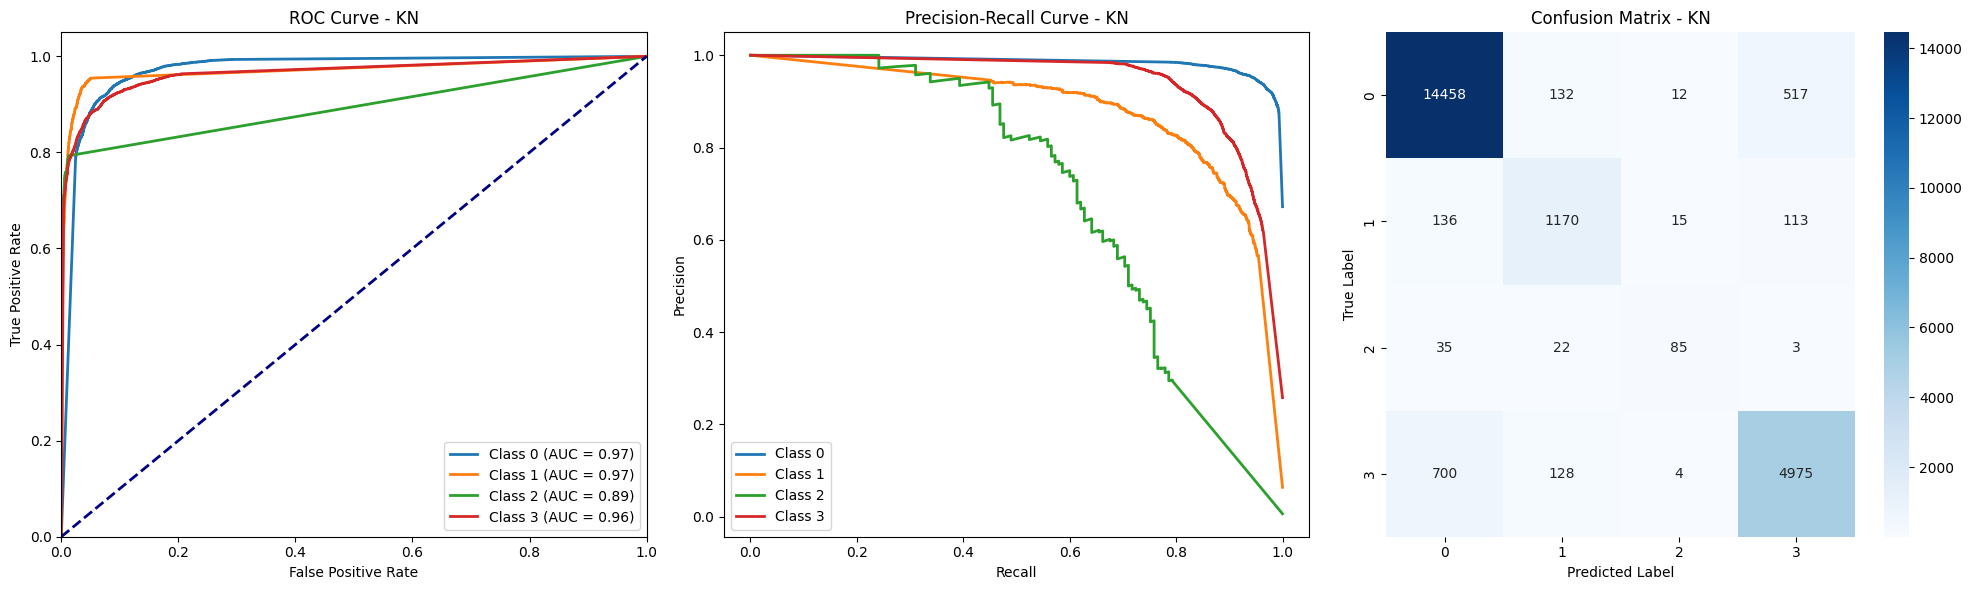

Training and plotting for RF


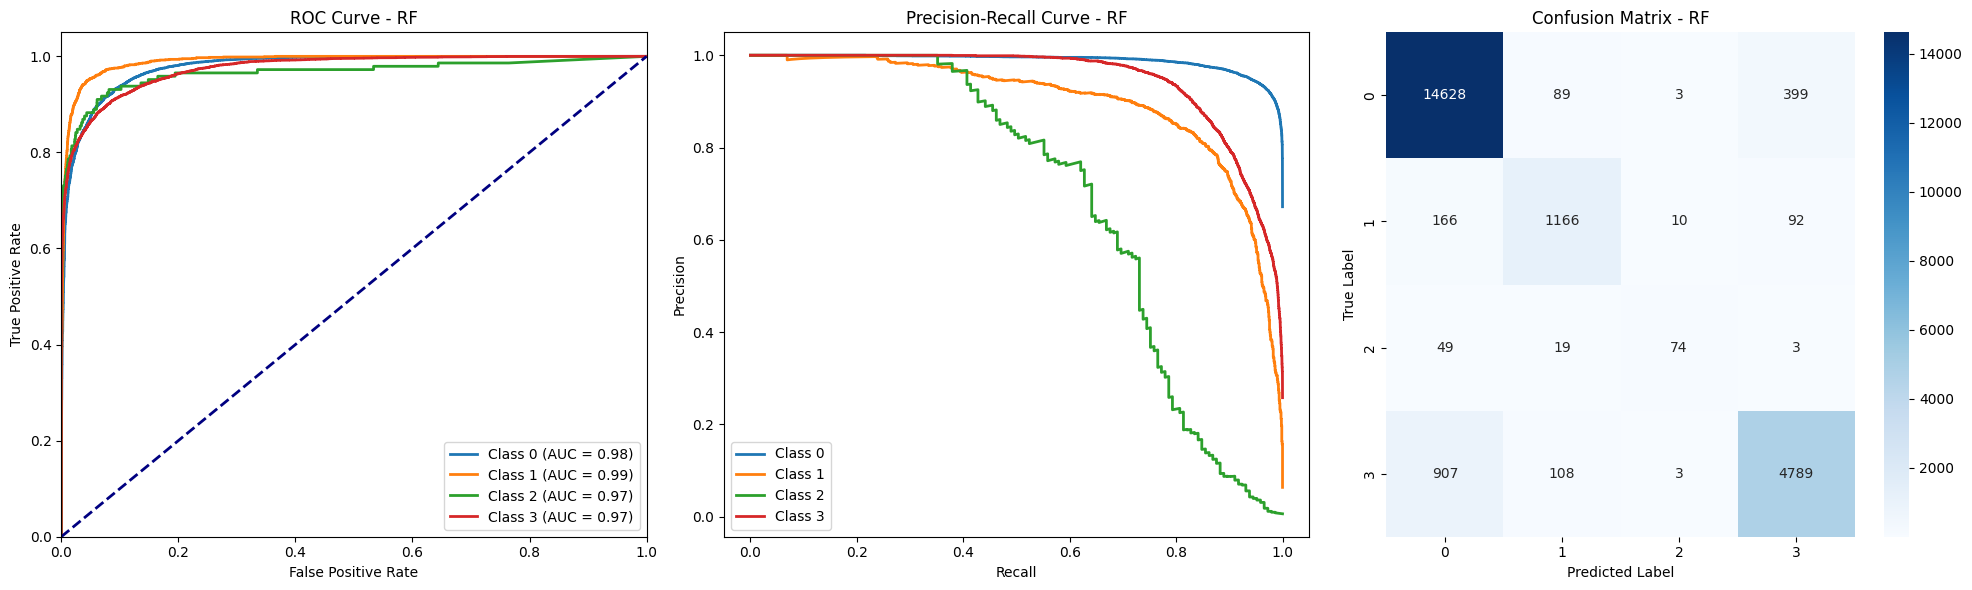

Training and plotting for AdaBoost


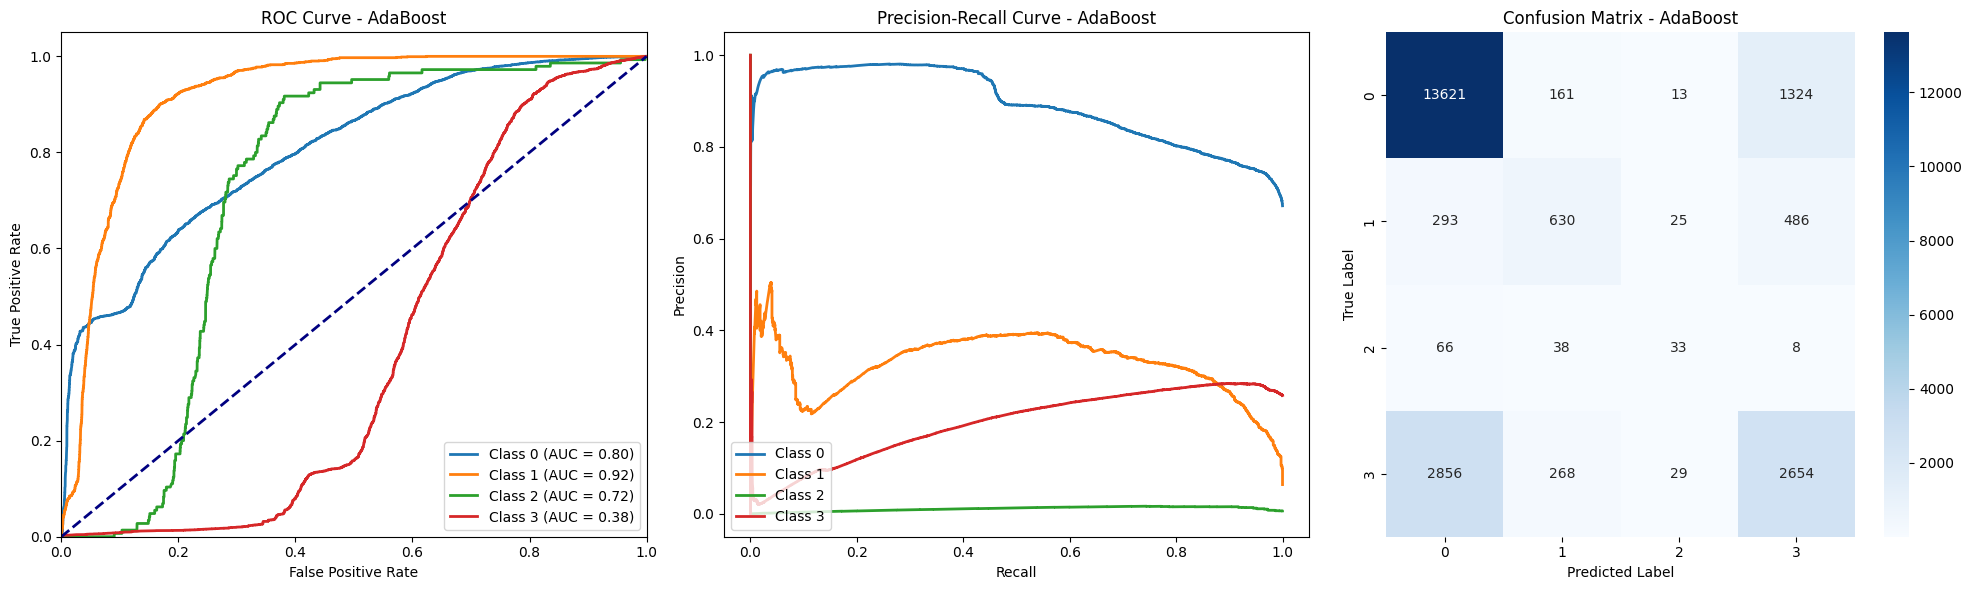

Training and plotting for ETC


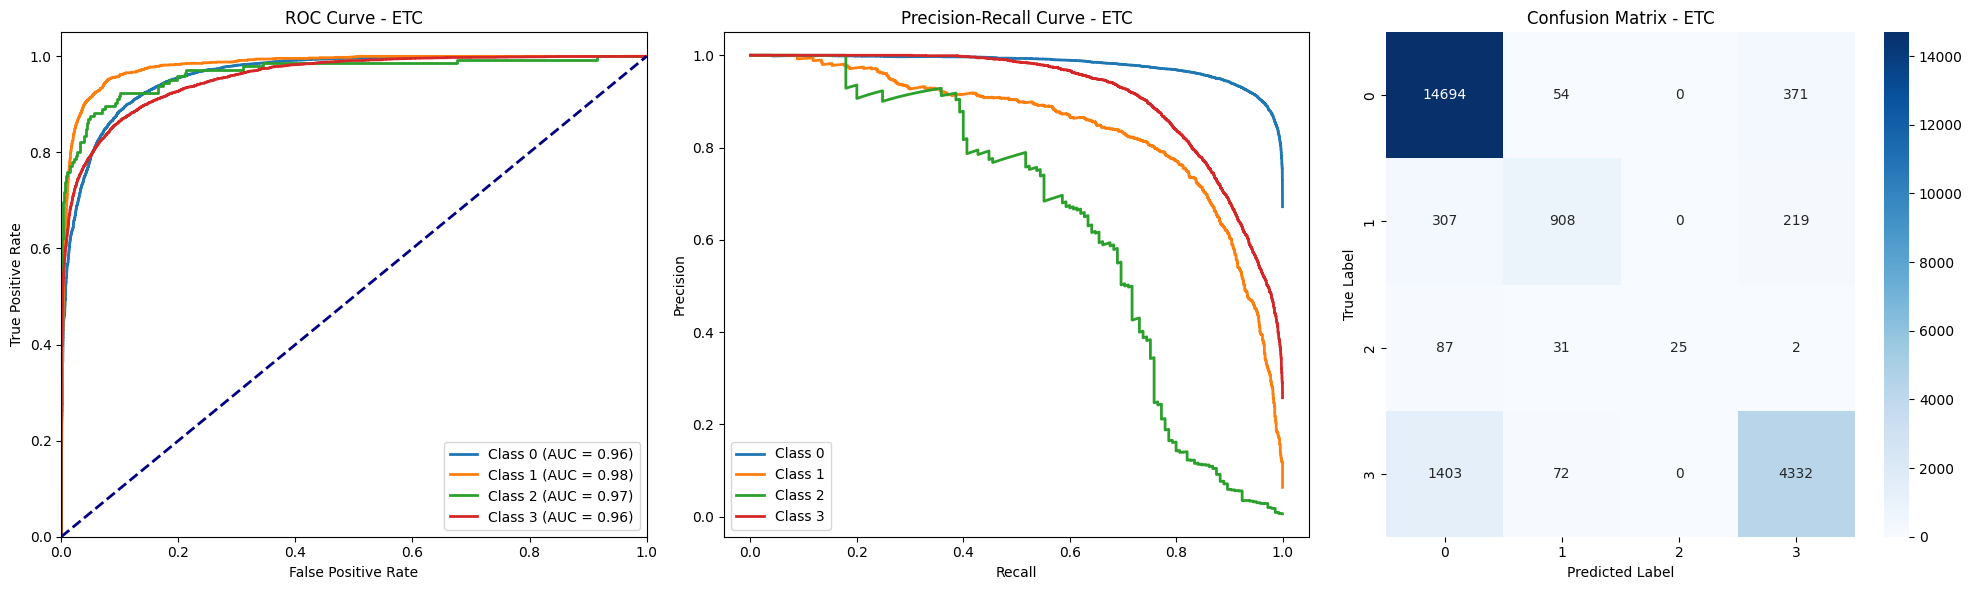

Training and plotting for GBDT


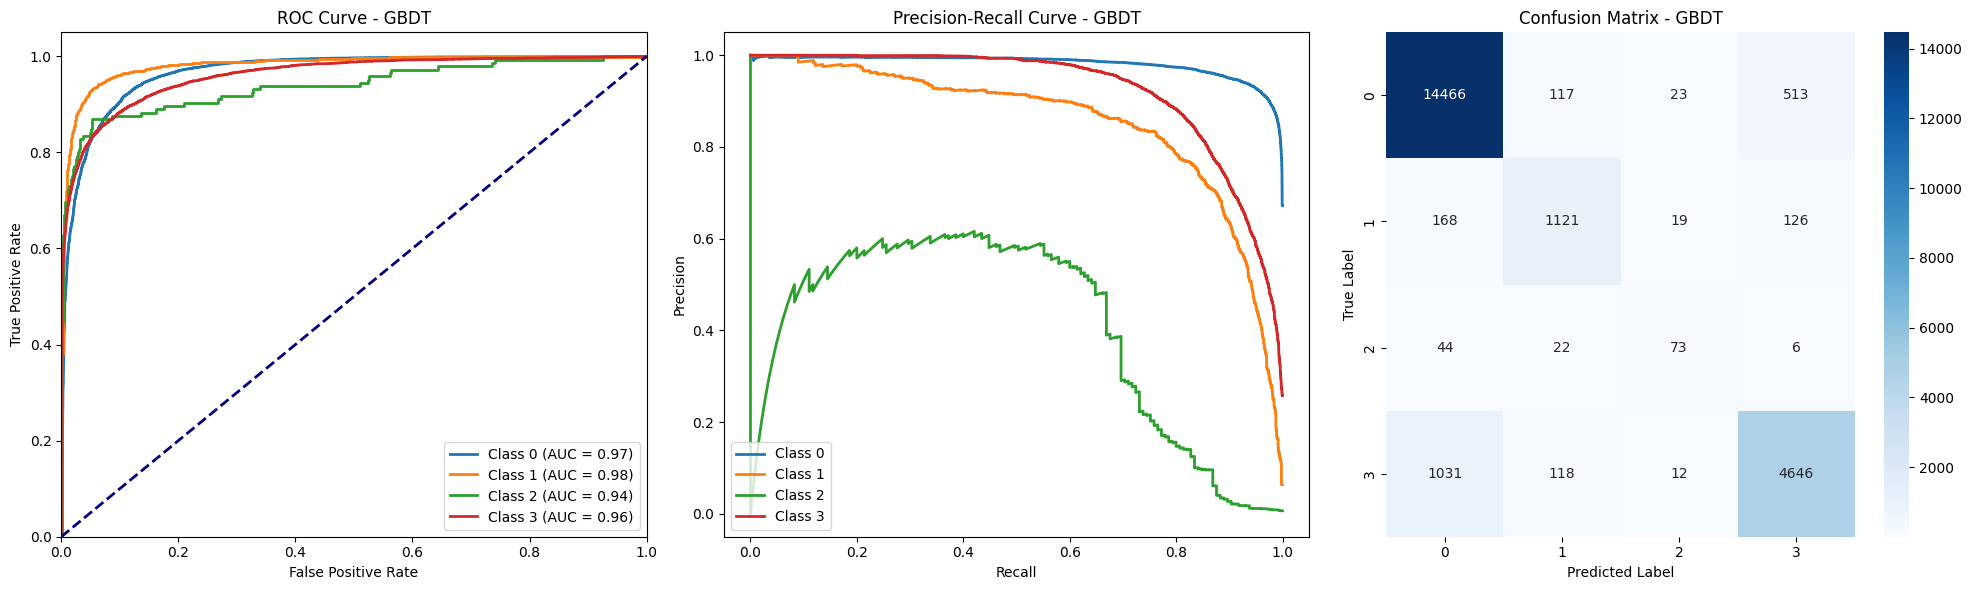

In [26]:
plot_metrics(clfs, X_train, y_train, X_test, y_test)

In [27]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores, 'Recall': recall_scores, "F1_score": f1_scores}).sort_values('Precision',ascending=False)

performance_df

,Algorithm,Accuracy,Precision,Recall,F1_score
2,KN,0.919262,0.918605,0.919262,0.918781
3,RF,0.917885,0.916909,0.917885,0.916379
6,GBDT,0.902288,0.900764,0.902288,0.900792
5,ETC,0.886870,0.886378,0.886870,0.881111
0,DT,0.839236,0.838538,0.839236,0.838596
4,AdaBoost,0.752633,0.735372,0.752633,0.739425
1,LR,0.718818,0.694487,0.718818,0.700081


## **Logistic Regression feature plot**

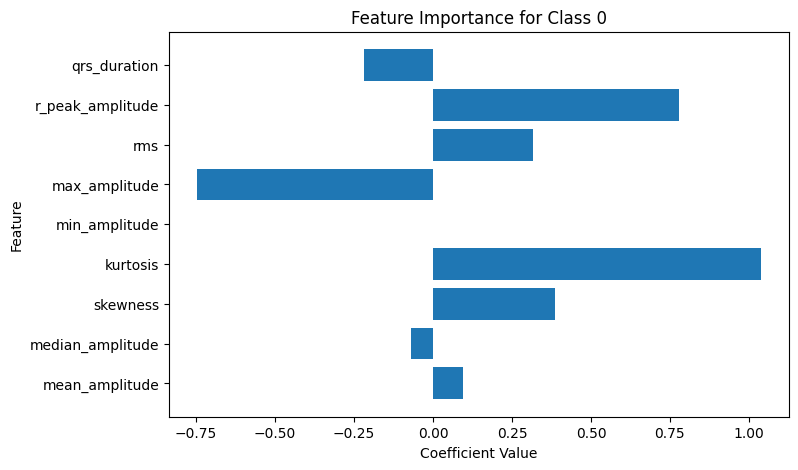

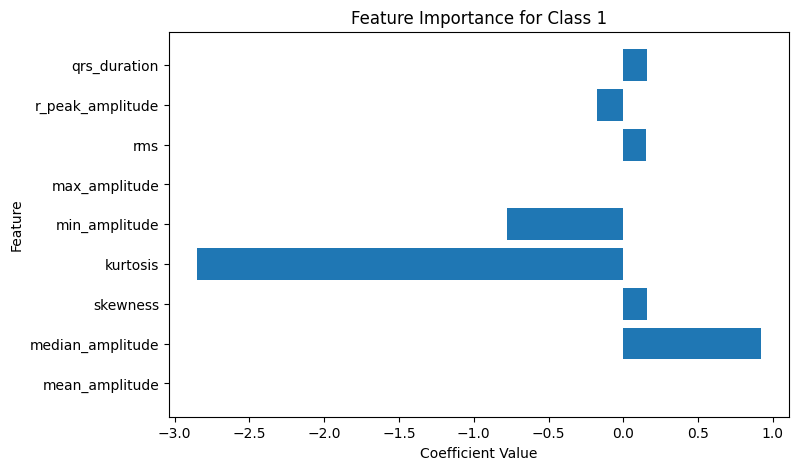

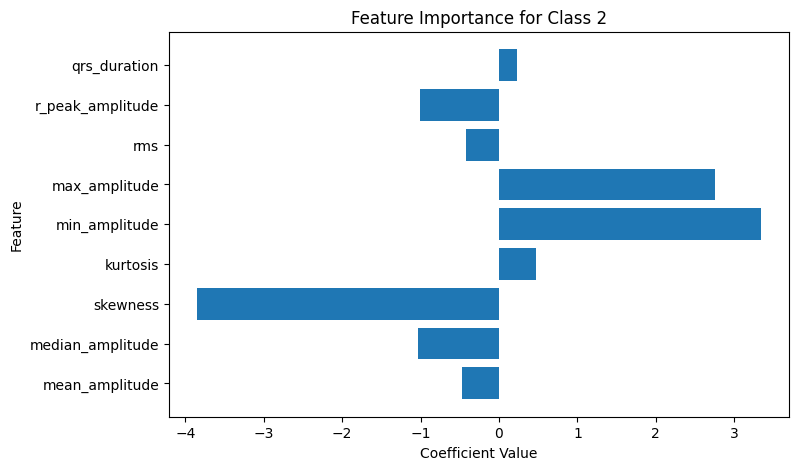

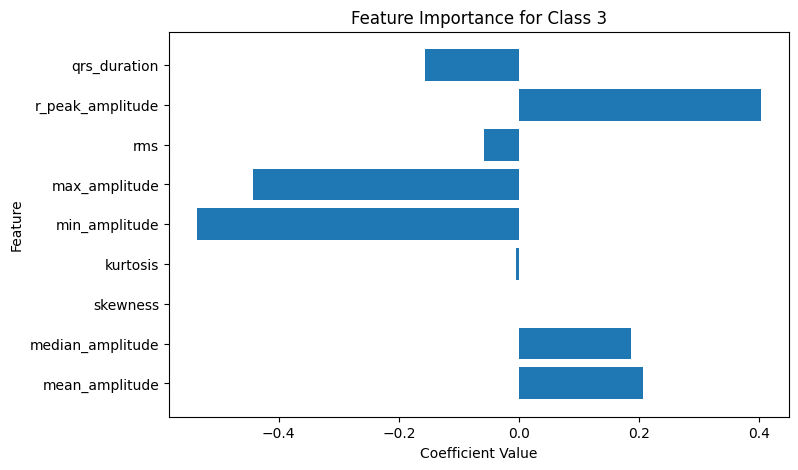

In [28]:
feature_names = X_train.columns  # Feature names
coef = lrc.coef_  # Get coefficients (shape: [n_classes, n_features])

for i, class_coef in enumerate(coef):
    plt.figure(figsize=(8, 5))
    plt.barh(feature_names, class_coef)
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.title(f"Feature Importance for Class {i}")
    plt.show()


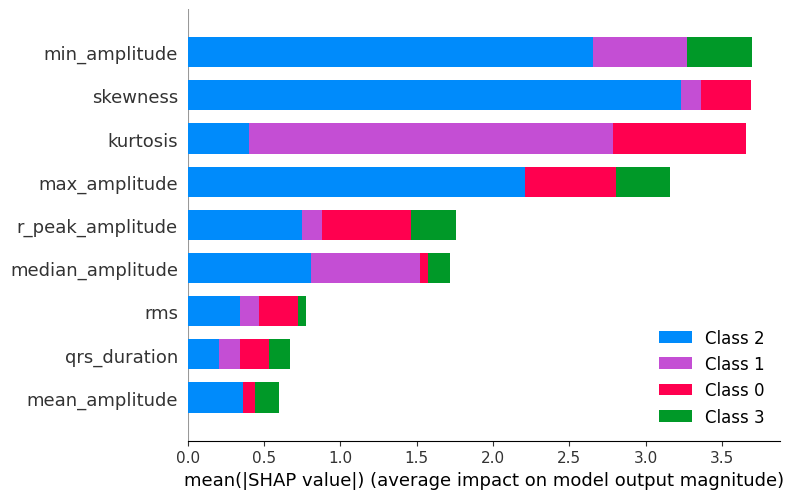

In [29]:
import shap

explainer = shap.LinearExplainer(lrc, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

# Ensure X_test is a DataFrame with proper column names
shap.summary_plot(shap_values, X_test)


## **Dicision Tree**

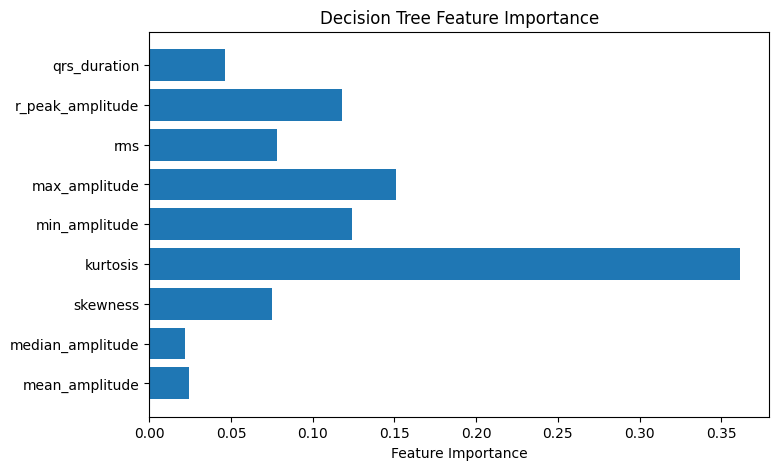

In [30]:
importances = dtc.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Decision Tree Feature Importance")
plt.show()


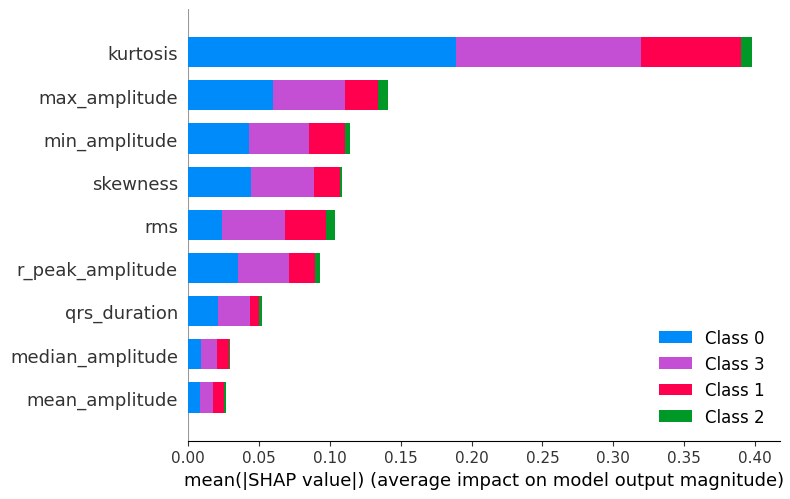

In [31]:
import shap
explainer = shap.TreeExplainer(dtc)
shap_values = explainer.shap_values(X_train)

# Summary Plot (Feature impact on predictions)
shap.summary_plot(shap_values, X_train)


## **Random forest**

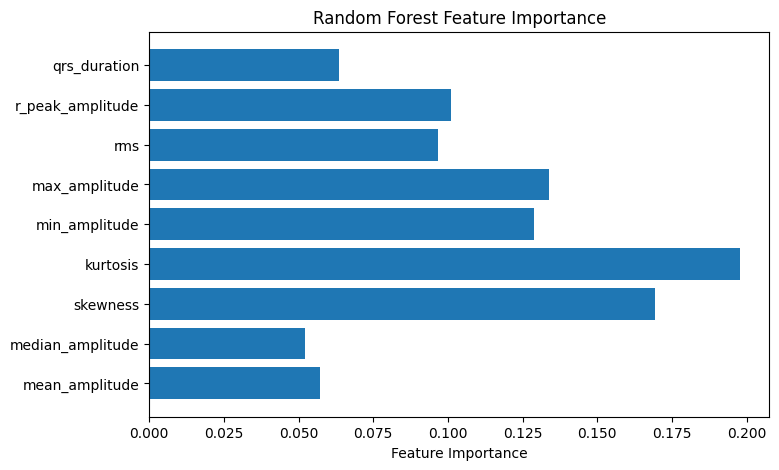

In [32]:
importances = rfc.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()


## **AdaBoost**

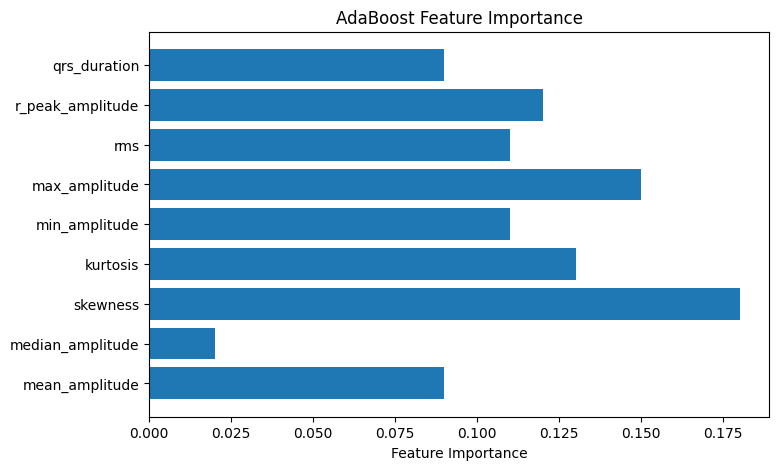

In [33]:
importances = abc.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("AdaBoost Feature Importance")
plt.show()


## **Extra tree Classifier**

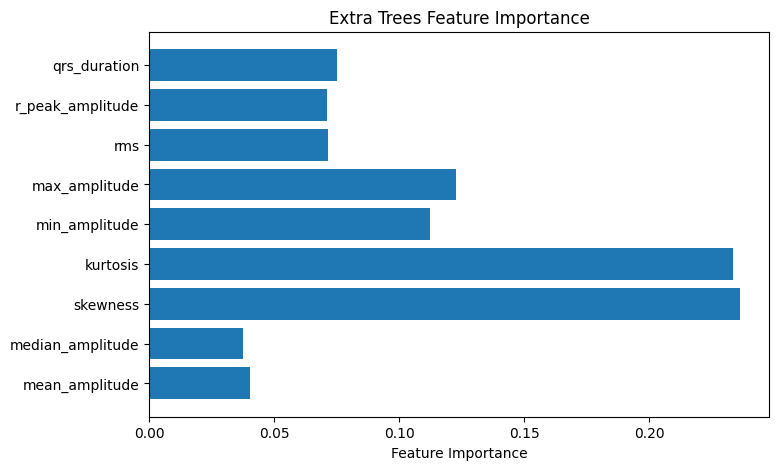

In [34]:
importances = etc.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Extra Trees Feature Importance")
plt.show()


## **Gradient Boosting**

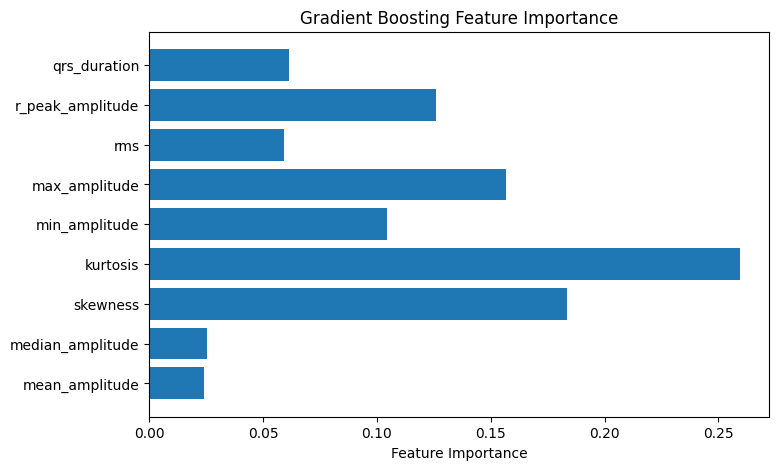

In [35]:
importances = gbdt.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Gradient Boosting Feature Importance")
plt.show()
